# Perform GSEA using GSEAPY  

Following the potocol defined here: https://gseapy.readthedocs.io/en/latest/gseapy_tutorial.html#use-gsea-command-or-gsea


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
import pandas as pd
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gp.__version__

'0.9.15'

In [82]:
df2.head()
print(df2[1].min(),df2[1].max())

-3.11529396116158 6.78831899793425


## Create gene lists

In [103]:
def createGLists(zth=3,nTop= None,col=1):
    import csv 
    from openpyxl import load_workbook


    with open('../dat/1908/20190812_Arrojo_genesets.gmt','w') as f:
        wb = load_workbook(filename = '../dat/1908/Arrojo_e_Drigo_biorxiv.alpha_states.xlsx')
        tsv_writer = csv.writer(f, delimiter='\t')
        for s in ['Alpha-state '+str(i) for i in range(1,5)]:
            print(s)
            ws=wb[s]
            df=pd.DataFrame(ws.values)
            df2 = df[1:]
            df2.columns=df.loc[0].tolist()
            df2=df2.set_index('gene_name')
            cols=df2.columns            
            x=df2[df2.Z> zth].sort_values(by=cols[col],ascending=False).index.tolist()
            print(len(x))
            x.insert(0,s +' up')
            x.insert(0,s +' up')
            if(nTop==None):
                tsv_writer.writerow(x)
            else:
                tsv_writer.writerow(x[:(nTop+2)])
            x=df2[df2.Z< -zth].sort_values(by=cols[col],ascending=True).index.tolist()
            print(len(x))
            x.insert(0,s +' down')
            x.insert(0,s +' down')
            if(nTop==None):
                tsv_writer.writerow(x)
            else:
                tsv_writer.writerow(x[:(nTop+2)])


        wb = load_workbook(filename = '../dat/1908/Arrojo_e_Drigo_biorxiv.beta_states.xlsx')
        for s in ['Beta-state{0} genes'.format(str(i)) for i in range(1,4)]:
            
            print(s)
            ws=wb[s]
            df=pd.DataFrame(ws.values)
            df2 = df[1:]
            df2.columns=df.loc[0].tolist()
            df2=df2.set_index('gene_name')
            cols=df2.columns
            x=df2[df2[cols[1]]> zth].sort_values(by=cols[col],ascending=False).index.tolist()
            print(len(x))
            x.insert(0,s +' up')
            x.insert(0,s +' up')
            if(nTop==None):
                tsv_writer.writerow(x)
            else:
                tsv_writer.writerow(x[:(nTop+2)])

            x=df2[df2[cols[1]] < -zth].sort_values(by=cols[col],ascending=True).index.tolist()
            print(len(x))
            x.insert(0,s +' down')
            x.insert(0,s +' down')
            if(nTop==None):
                tsv_writer.writerow(x)
            else:
                tsv_writer.writerow(x[:(nTop+2)])

            

In [137]:
celltype='alpha'
nperm=1000
rseed=1000
rnkfile="../dat/figdata/fig2_prom_ttest_res.csv"
glist='../dat/glists/gsea.gmt'
rank_metrics='odds'
gene_exp_alpha = pd.read_csv(rnkfile)[['celltype','gene',rank_metrics]]
rnk = gene_exp_alpha.loc[gene_exp_alpha["celltype"]==celltype].drop(columns='celltype').sort_values(by=rank_metrics)
rnk['odds'] =np.log2(rnk['odds'])
rnk=rnk.reset_index(drop=True)
df=rnk.drop(columns='gene')        

for i in  rnk.index[(rnk['odds']==np.inf).tolist()].tolist():
    rnk.iloc[i,1]= float(df[~df.isin([np.inf])].max(0)*(1+np.random.uniform()/100))

for i in  rnk.index[(rnk['odds']==-np.inf).tolist()].tolist():
    rnk.iloc[i,1]= float(df[~df.isin([-np.inf])].min(0)*(1+np.random.uniform()/100))

display(rnk.max())
rnk['odds']=rnk['odds']/max(abs(rnk['odds']))
display(rnk.max())
display(rnk.min())

gene    hsa-mir-1199
odds         4.86924
dtype: object

gene    hsa-mir-1199
odds        0.810276
dtype: object

gene    A1BG
odds      -1
dtype: object

In [141]:
def run_GSEA_gene(celltype,nperm=1000,rseed=1000,
             rnkfile="../dat/figdata/fig2_prom_ttest_res.csv",
             glist='../dat/glists/gsea.gmt',col=1,
             rank_metrics='odds',zth=3,nTop=500,**kwargs):
    '''
    col=1 - Z, 0 - logFC
    '''

    gene_exp_alpha = pd.read_csv(rnkfile)[['celltype','gene',rank_metrics]]
            
    #gene_exp_alpha.head()
    rnk = gene_exp_alpha.loc[gene_exp_alpha["celltype"]==celltype].drop(columns='celltype').sort_values(by=rank_metrics)
    if(rank_metrics=='odds'):
        rnk['odds'] =np.log2(rnk['odds'])
        rnk=rnk.reset_index(drop=True)
        df=rnk.drop(columns='gene')        
        np.random.seed(seed=rseed)
        for i in  rnk.index[(rnk['odds']==np.inf).tolist()].tolist():
            rnk.iloc[i,1]= float(df[~df.isin([np.inf])].max(0)*(1+np.random.uniform()/100))

        for i in  rnk.index[(rnk['odds']==-np.inf).tolist()].tolist():
            rnk.iloc[i,1]= float(df[~df.isin([-np.inf])].min(0)*(1+np.random.uniform()/100))
        rnk['odds']=rnk['odds']/max(abs(rnk['odds']))
        
    print(rnk.shape)
    print(rnk.head(1))
    print(rnk.tail(1))
    print('zth:{0}'.format(zth))
    createGLists(zth,nTop,col=col)
    gs_res_a = gp.prerank(rnk=rnk, # or data='./P53_resampling_data.txt'
                     gene_sets=glist, # enrichr library names or gmt file
                     #set permutation_type to phenotype if samples >=15
                     permutation_num=nperm, # reduce number to speed up test
                     outdir=None,  # do not write output to disk
                     no_plot=True, # Skip plotting
                     #weighted_score_type=1,
                     #ascending=False,
                        seed=rseed,
                     min_size=1,
                     max_size=5000,
                     processes=8,**kwargs)
                     #format='png')
    return(gs_res_a)


## alpha & beta

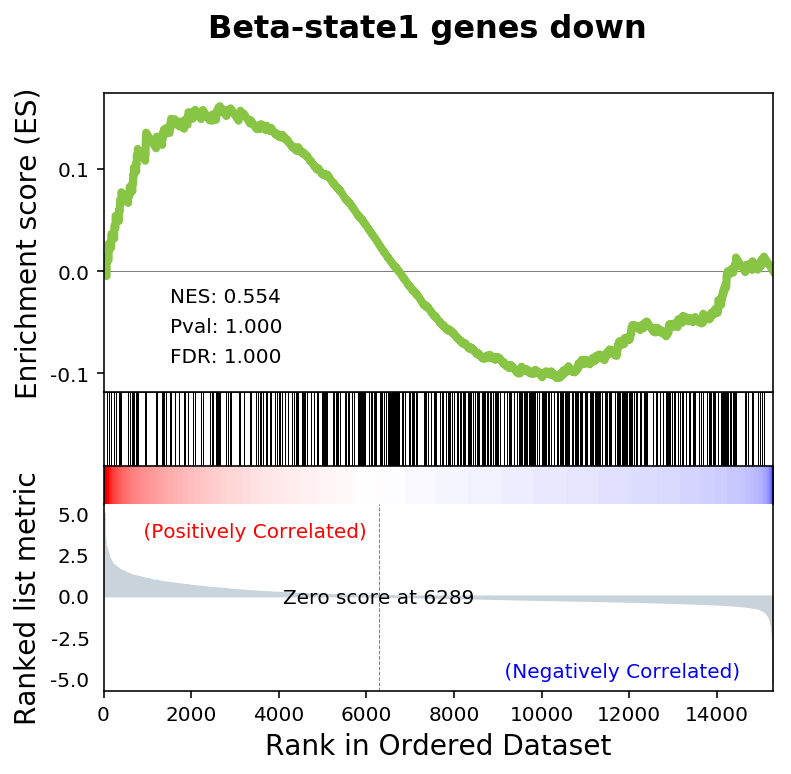

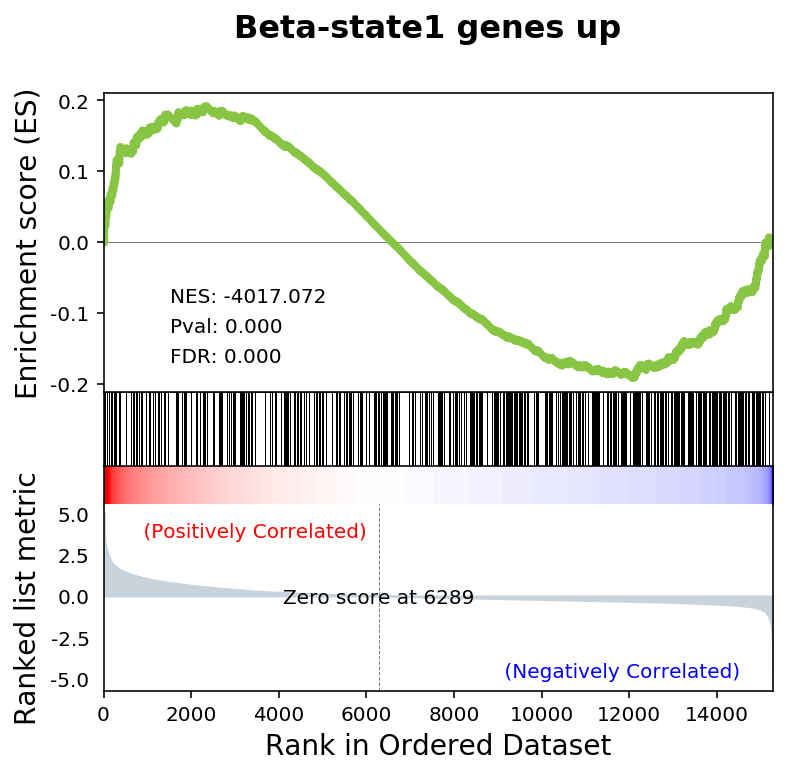

In [106]:
from gseapy.plot import gseaplot, heatmap
tm='Beta-state1 genes down'
gseaplot(gs_res_b.ranking, term=tm, **gs_res_b.results[tm])
tm='Beta-state1 genes up'
gseaplot(gs_res_b.ranking, term=tm, **gs_res_b.results[tm])

In [154]:
display(gs_res_a.res2d[gs_res_a.res2d.pval<0.1].sort_index())
gs_res_b.res2d[gs_res_b.res2d.pval<0.1].sort_index()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.260382,-11.743603,0.000000,0.000000,500,488,CACFD1;LLGL2;ABHD12;PARVB;PAK4;SIL1;ATP5G2;SLC...,RNH1;ELMO3;RPL37A;PRDX2;LAMTOR2;SEZ6L2;PRMT1;S...
Alpha-state 2 down,-0.160638,-7.650978,0.006983,0.006148,500,483,DOT1L;SLC7A8;ATXN10;MTCH1;CACFD1;ILF3;ABHD12;W...,RPL24;TMOD1;NPC2;SUMO3;C21orf2;HMG20B;DAP;BTG2...
Alpha-state 3 up,-0.148931,-6.756568,0.026596,0.060069,500,493,ARPC2;PTPLAD1;CNDP2;HNRNPH1;CD36;AK2;RIN2;MLIP...,ANAPC13;ENPP5;SRA1;AK1;SLC3A2;KIAA1279;VDAC3;G...
Beta-state1 genes up,-0.231253,-10.624154,0.000000,0.000000,500,489,PI4KA;MTCH1;CACFD1;LLGL2;ABHD12;ABCC8;GCG;PAK4...,RNH1;RPL37A;SEZ6L2;CAPN1;NGRN;PRMT1;SCAMP4;FAM...
Beta-state2 genes down,-0.164283,-7.721493,0.002740,0.005830,500,480,SLC7A8;RAB2A;MTCH1;MBTPS1;LMBR1;ABHD12;SAFB;GC...,SCCPDH;HEXB;TMOD1;UBE2J2;SUMO3;POLDIP2;DAP;SZR...
Beta-state3 genes up,-0.200147,-9.278789,0.000000,0.000000,500,480,MOK;SLC7A8;GSTZ1;SUMO1;LLGL2;LIMA1;AP1B1;TPCN1...,SEC61B;TMEM66;UBE2R2;TIMM22;ALDH7A1;PTGES3;SLC...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.242667,-51.961763,0.000000,0.000000,500,488,ATP2A3;NCOR2;ECI1;UCP2;RAP1GAP;MAP2K2;MLXIPL;P...,MFSD10;PHLDB3;TRAPPC1;POLR2L;RRBP1;COX8A;TCF25...
Alpha-state 2 down,-0.176859,-38.490700,0.000000,0.008632,500,483,MTCH1;RAP1GAP;ABCC8;ATP1A1;HNRNPM;PFKL;WDR45B;...,PPIA;RNH1;DNAJB1;TRAF4;RAB1B;CIB1;BAP1;EIF1;RP...
Alpha-state 3 up,-0.178882,-40.316595,0.000000,0.009591,500,492,PGM1;TECR;TPD52;HDLBP;KCNMB2;LSM4;CNDP2;AGT;AS...,PDCD4;ARPC5;FDPS;MFSD10;RPAIN;TRAPPC1;SLC39A1;...
Beta-state1 genes up,-0.195986,-44.365825,0.000000,0.002877,500,488,PI4KA;ATP2A3;NCOR2;INS;MTCH1;ECI1;POR;PEPD;C1o...,TRAPPC1;CSNK1D;SNCB;POLR2L;COX8A;TCF25;APLP1;N...
Beta-state2 genes down,-0.151832,-34.375814,0.000000,0.039132,500,479,MTCH1;TPD52;BTG3;ASB9;ATP1A1;HNRNPM;LSM4;TMCO3...,NGRN;RPS7;ACADVL;TMEM115;PGAM1;VCP;H3F3A;HNRNP...
Beta-state3 genes up,-0.153887,-32.796757,0.006135,0.050149,500,480,ZNF143;RNF4;TPD52;GSTZ1;BTG3;ASB9;PRKAG2;IPO13...,CNOT8;LPIN1;UBE2V1;PTMA;INTS1;LARP4;SLMAP;LETM...


In [153]:
gs_res_a=run_GSEA_gene(celltype='alpha',
                       nperm=4000,
                       rseed=400,
                       zth=3,
                       col=1, 
                       nTop=500,
                       weighted_score_type=.5,                       
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

gs_res_b=run_GSEA_gene(celltype='beta',
                       nperm=4000,
                       rseed=400,
                       zth=3,
                       weighted_score_type=.5,
                       nTop=500,
                       #col=0,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

display(gs_res_a.res2d.sort_index())
gs_res_b.res2d.sort_index()


(21715, 2)
     gene      odds
0  ZNF106 -0.992467
          gene      odds
21714  PLEKHS1  0.806284
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 13:13:22,908 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


(21825, 2)
   gene      odds
0  PDHX -0.996919
        gene      odds
21824  TIGIT  0.968698
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 13:14:02,677 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 down,-0.119619,-5.463139,0.409333,0.474154,500,486,ST8SIA3;TXNDC15;PPFIA1;XPO5;SUMO1;CEP63;SLAIN2...,TMEM66;UBE2R2;PTGES3;TMEM60;TMEM30B;MRPL45;RNF...
Alpha-state 1 up,-0.260382,-11.743603,0.000000,0.000000,500,488,CACFD1;LLGL2;ABHD12;PARVB;PAK4;SIL1;ATP5G2;SLC...,RNH1;ELMO3;RPL37A;PRDX2;LAMTOR2;SEZ6L2;PRMT1;S...
Alpha-state 2 down,-0.160638,-7.650978,0.006983,0.006148,500,483,DOT1L;SLC7A8;ATXN10;MTCH1;CACFD1;ILF3;ABHD12;W...,RPL24;TMOD1;NPC2;SUMO3;C21orf2;HMG20B;DAP;BTG2...
Alpha-state 2 up,0.108183,0.996316,0.907442,0.895864,500,485,MYSM1;DDAH1;CSNK2A2;STT3A;ZNF587;EYA3;LIMCH1;T...,MYSM1;DDAH1;CSNK2A2;STT3A;ZNF587;EYA3;LIMCH1;T...
Alpha-state 3 down,0.113855,1.045025,0.815709,1.000000,500,481,DOT1L;MYSM1;TPM4;KMT2D;RALGAPA1;TNS3;MAML3;DTN...,DOT1L;MYSM1;TPM4;KMT2D;RALGAPA1;TNS3;MAML3;DTN...
Alpha-state 3 up,-0.148931,-6.756568,0.026596,0.060069,500,493,ARPC2;PTPLAD1;CNDP2;HNRNPH1;CD36;AK2;RIN2;MLIP...,ANAPC13;ENPP5;SRA1;AK1;SLC3A2;KIAA1279;VDAC3;G...
Alpha-state 4 down,-0.130207,-5.930792,0.174667,0.269117,500,490,CNDP2;NDRG1;SH3KBP1;TMEM30A;ABHD12;HNRNPH1;PAR...,CMAS;LMAN2;EIF4EBP2;DNASE2;ASNA1;UBXN1;GNPDA1;...
Alpha-state 4 up,-0.130358,-6.117020,0.150479,0.213976,500,487,SLC7A8;TSG101;AACS;PRUNE;XPO5;OAT;TM2D3;GDA;TR...,SCG5;VAMP4;RBBP7;NOSIP;NDN;RPS7;CIAO1;RPS18;PA...
Beta-state1 genes down,-0.121542,-5.749372,0.309491,0.335914,500,484,STT3A;KIAA0430;RAB2A;SUMO1;CDK5RAP2;GNB5;RNF41...,PFKFB2;WDR12;RPS7;BCLAF1;IFNGR1;GOLGA4;CIAO1;T...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 down,-0.122602,-33.988491,0.256000,0.036447,500,484,TVP23B;FABP5;ANKFY1;TPD52;CPSF2;CASC3;CHD2;MRP...,RPS27A;CIAO1;PAPSS1;FAM175B;SMYD2;JMJD1C;TSC22...
Alpha-state 1 up,-0.242667,-51.961763,0.000000,0.000000,500,488,ATP2A3;NCOR2;ECI1;UCP2;RAP1GAP;MAP2K2;MLXIPL;P...,MFSD10;PHLDB3;TRAPPC1;POLR2L;RRBP1;COX8A;TCF25...
Alpha-state 2 down,-0.176859,-38.490700,0.000000,0.008632,500,483,MTCH1;RAP1GAP;ABCC8;ATP1A1;HNRNPM;PFKL;WDR45B;...,PPIA;RNH1;DNAJB1;TRAF4;RAB1B;CIB1;BAP1;EIF1;RP...
Alpha-state 2 up,-0.071487,-14.359244,1.000000,1.000000,500,485,EDIL3;FTO;ARID1B;PPP2R5C;AMFR;CTBP1;SLC39A11;S...,INSR;FAM76A;TRIM13;RTN4;CAPZA1;ZNF326;YWHAE;ND...
Alpha-state 3 down,-0.109518,-22.366383,0.589595,0.906636,500,478,KMT2D;NCOR2;RFX3;MAP3K2;FABP5;FOXN3;RUFY3;SENP...,RPL13A;BNIP2;SREK1;WAPAL;MARCKS;ARID5B;MKNK2;P...
Alpha-state 3 up,-0.178882,-40.316595,0.000000,0.009591,500,492,PGM1;TECR;TPD52;HDLBP;KCNMB2;LSM4;CNDP2;AGT;AS...,PDCD4;ARPC5;FDPS;MFSD10;RPAIN;TRAPPC1;SLC39A1;...
Alpha-state 4 down,-0.125717,-27.685728,0.143750,0.247455,500,491,EDIL3;ATP2A3;AMFR;HDLBP;CTBP1;POR;SENP7;FLCN;T...,RAB14;NDUFA3;PDGFA;SYT11;ATP5I;MCOLN1;SORT1;PS...
Alpha-state 4 up,-0.122385,-24.016169,0.245810,0.712439,500,487,TSG101;FABP5;TK2;COMMD9;PEPD;EIF3D;FAM118A;RNF...,CYSTM1;UBE2V1;PTMA;LARP4;NAPB;RPS27A;CIAO1;PIM...
Beta-state1 genes down,-0.124354,-28.358192,0.222222,0.219400,500,484,TVP23B;ZNF143;TPD52;SENP7;MRPS27;ARHGAP1;RNF41...,ARPC3;PARL;CNOT8;G3BP2;PTMA;EIF4G2;RAB18;NAPB;...


In [146]:
gs_res_a=run_GSEA_gene(celltype='alpha',
                       nperm=1000,
                       rseed=100,
                       zth=3,
                       col=1, 
                       nTop=200,
                       weighted_score_type=1,                       
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

gs_res_b=run_GSEA_gene(celltype='beta',
                       nperm=4000,
                       rseed=1000,
                       zth=3,
                       weighted_score_type=1,
                       nTop=200,
                       #col=0,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

display(gs_res_a.res2d[gs_res_a.res2d.pval<0.01].sort_index())
gs_res_b.res2d[gs_res_b.res2d.pval<0.01].sort_index()

(21715, 2)
     gene      odds
0  ZNF106 -0.991824
          gene      odds
21714  PLEKHS1  0.806326
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 13:01:05,097 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


(21825, 2)
   gene      odds
0  PDHX -0.990562
        gene      odds
21824  TIGIT  0.963236
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 13:01:14,361 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.384976,-23.726823,0.0,0.000000,200,194,ATP5G2;SLC29A4;PEMT;VAT1;PPP1R1A;AES;CELF3;PKM...,GUK1;TMED3;CLDN7;RPL37A;SEZ6L2;FAM50A;DPM3;NDU...
Beta-state3 genes up,-0.278169,-12.655036,0.0,0.463251,200,187,MOK;CD99;C22orf42;SLC37A4;C9orf3;TNFSF13B;TSPA...,PPAPDC1B;EMP2;RPS15;HMGN2;ARF4;RPL35;H3F3A;EIF...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.353247,-75.080439,0.0,0.041988,200,194,ATP2A3;PEMT;SLC29A4;RAD23A;VAT1;CELF3;PCSK1N;M...,TRAPPC1;POLR2L;COX8A;NPC2;NDUFS7;TCEB2;GNB2;RP...


In [147]:
gs_res_a=run_GSEA_gene(celltype='alpha',
                       nperm=1000,
                       rseed=100,
                       zth=3,
                       col=1, 
                       nTop=500,
                       weighted_score_type=1.5,                       
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

gs_res_b=run_GSEA_gene(celltype='beta',
                       nperm=4000,
                       rseed=1000,
                       zth=3,
                       weighted_score_type=1.5,
                       nTop=500,
                       #col=0,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

display(gs_res_a.res2d[gs_res_a.res2d.pval<0.01].sort_index())
gs_res_b.res2d[gs_res_b.res2d.pval<0.01].sort_index()

(21715, 2)
     gene      odds
0  ZNF106 -0.991824
          gene      odds
21714  PLEKHS1  0.806326
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 13:01:58,536 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


(21825, 2)
   gene      odds
0  PDHX -0.990562
        gene      odds
21824  TIGIT  0.963236
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 13:02:09,263 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.312217,-1185.14741,0.0,0.0,500,488,CACFD1;LLGL2;ABHD12;PARVB;PAK4;SIL1;ATP5G2;SLC...,PKN1;HLA-C;AP1S1;DRAP1;TRAPPC1;TLN1;AKT1S1;TBC...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,


In [145]:
gs_res_a=run_GSEA_gene(celltype='alpha',
                       nperm=1000,
                       rseed=100,
                       zth=3,
                       col=1, 
                       nTop=500,
                       weighted_score_type=2,                       
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

gs_res_b=run_GSEA_gene(celltype='beta',
                       nperm=4000,
                       rseed=1000,
                       zth=3,
                       weighted_score_type=2,
                       nTop=500,
                       #col=0,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

display(gs_res_a.res2d[gs_res_a.res2d.pval<0.01].sort_index())
gs_res_b.res2d[gs_res_b.res2d.pval<0.01].sort_index()

(21715, 2)
     gene      odds
0  ZNF106 -0.991824
          gene      odds
21714  PLEKHS1  0.806326
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:59:22,977 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


(21825, 2)
   gene      odds
0  PDHX -0.990562
        gene      odds
21824  TIGIT  0.963236
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:59:33,491 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 2 up,0.644251,1.274515,0.009036,0.091359,500,485,STT3A;DDAH1;CSNK2A2;MYSM1;ZNF587;EYA3;LIMCH1;T...,STT3A;DDAH1;CSNK2A2;MYSM1;ZNF587;EYA3;LIMCH1;T...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,


In [144]:
gs_res_a=run_GSEA_gene(celltype='alpha',
                       nperm=1000,
                       rseed=100,
                       zth=3,
                       col=1, 
                       nTop=None,
                       weighted_score_type=2,                       
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

gs_res_b=run_GSEA_gene(celltype='beta',
                       nperm=4000,
                       rseed=1000,
                       zth=3,
                       weighted_score_type=2,
                       nTop=None,
                       #col=0,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

display(gs_res_a.res2d[gs_res_a.res2d.pval<0.01].sort_index())
gs_res_b.res2d[gs_res_b.res2d.pval<0.01].sort_index()

(21715, 2)
     gene      odds
0  ZNF106 -0.991824
          gene      odds
21714  PLEKHS1  0.806326
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:57:37,723 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


(21825, 2)
   gene      odds
0  PDHX -0.990562
        gene      odds
21824  TIGIT  0.963236
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:57:58,274 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 2 up,0.598571,1.183507,0.0,0.057004,2262,2205,THBS1;NFIB;PPP2R2C;STT3A;TAF1;SCN3A;RYK;DDAH1;...,THBS1;NFIB;PPP2R2C;STT3A;TAF1;SCN3A;RYK;DDAH1;...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,


In [143]:
gs_res_a=run_GSEA_gene(celltype='alpha',
                       nperm=1000,
                       rseed=100,
                       zth=3,
                       col=1, 
                       nTop=None,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

gs_res_b=run_GSEA_gene(celltype='beta',
                       nperm=4000,
                       rseed=1000,
                       zth=3,
                       weighted_score_type=1,
                       nTop=None,
                       #col=0,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

display(gs_res_a.res2d[gs_res_a.res2d.pval<0.01].sort_index())
gs_res_b.res2d[gs_res_b.res2d.pval<0.01].sort_index()

(21715, 2)
     gene      odds
0  ZNF106 -0.991824
          gene      odds
21714  PLEKHS1  0.806326
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:56:03,936 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


(21825, 2)
   gene      odds
0  PDHX -0.990562
        gene      odds
21824  TIGIT  0.963236
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:56:24,365 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Beta-state3 genes up,-0.200006,-1097.30884,0.0,0.0,1126,1095,ARAF;MOK;SLC7A8;MAGI2;ANKRD6;GSTZ1;SUMO1;STX18...,IPO5;PPAPDC1B;EMP2;NASP;SLC35C1;DNTTIP2;ATP1B3...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,


In [142]:
gs_res_a=run_GSEA_gene(celltype='alpha',
                       nperm=1000,
                       rseed=100,
                       zth=3,
                       col=1, 
#                       nTop=500,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

gs_res_b=run_GSEA_gene(celltype='beta',
                       nperm=4000,
                       rseed=1000,
                       zth=3,
                       weighted_score_type=1,
#                       nTop=500,
                       #col=0,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

display(gs_res_a.res2d[gs_res_a.res2d.pval<0.01].sort_index())
gs_res_b.res2d[gs_res_b.res2d.pval<0.01].sort_index()

(21715, 2)
     gene      odds
0  ZNF106 -0.991824
          gene      odds
21714  PLEKHS1  0.806326
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:54:15,269 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


(21825, 2)
   gene      odds
0  PDHX -0.990562
        gene      odds
21824  TIGIT  0.963236
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:54:26,010 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.301419,-94.116907,0.0,0.190244,500,488,CACFD1;LLGL2;ABHD12;PARVB;PAK4;SIL1;ATP5G2;SLC...,RNH1;ELMO3;RPL37A;PRDX2;LAMTOR2;SEZ6L2;PRMT1;S...
Beta-state1 genes up,-0.253039,-112.126148,0.0,0.175610,500,489,PI4KA;MTCH1;CACFD1;LLGL2;ABHD12;ABCC8;GCG;PAK4...,RNH1;RPL37A;SEZ6L2;CAPN1;NGRN;PRMT1;SCAMP4;FAM...
Beta-state3 genes up,-0.238376,-92.446292,0.0,0.165854,500,480,MOK;SLC7A8;GSTZ1;SUMO1;LLGL2;LIMA1;AP1B1;TPCN1...,PPAPDC1B;EMP2;NASP;DNTTIP2;ATP1B3;PFDN4;RPS15;...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.267231,-2746.133651,0.0,0.391304,500,488,ATP2A3;NCOR2;ECI1;UCP2;RAP1GAP;MAP2K2;MLXIPL;P...,HSD17B14;PAK4;TMEM259;GIPC1;SLC25A39;TMEM184B;...
Alpha-state 2 down,-0.196658,-2093.204288,0.0,0.347826,500,483,MTCH1;RAP1GAP;ABCC8;ATP1A1;HNRNPM;PFKL;WDR45B;...,PPIA;RNH1;DNAJB1;TRAF4;RAB1B;CIB1;BAP1;EIF1;RP...


In [139]:
gs_res_a=run_GSEA_gene(celltype='alpha',
                       nperm=1000,
                       rseed=100,
                       zth=3,
                       col=1, 
                       nTop=500,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

gs_res_b=run_GSEA_gene(celltype='beta',
                       nperm=4000,
                       rseed=1000,
                       zth=3,
                       weighted_score_type=1,
                       nTop=500,
                       #col=0,
                       glist='../dat/1908/20190812_Arrojo_genesets.gmt')

display(gs_res_a.res2d[gs_res_a.res2d.pval<0.01].sort_index())
gs_res_b.res2d[gs_res_b.res2d.pval<0.01].sort_index()

(21715, 2)
     gene      odds
0  ZNF106 -0.995254
          gene      odds
21714  PLEKHS1  0.802529
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:49:37,218 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


(21825, 2)
   gene      odds
0  PDHX -0.993594
        gene      odds
21824  TIGIT  0.965611
zth:3
Alpha-state 1
4578
2423
Alpha-state 2
2262
1781
Alpha-state 3
1533
821
Alpha-state 4
2535
5779
Beta-state1 genes
3385
981
Beta-state2 genes
1397
1784
Beta-state3 genes
1126
4369


2019-08-26 12:49:47,501 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.301419,-113.776821,0.0,0.121827,500,488,CACFD1;LLGL2;ABHD12;PARVB;PAK4;SIL1;ATP5G2;SLC...,RNH1;ELMO3;RPL37A;PRDX2;LAMTOR2;SEZ6L2;PRMT1;S...
Beta-state1 genes up,-0.253026,-123.954843,0.0,0.182741,500,489,PI4KA;MTCH1;CACFD1;LLGL2;ABHD12;ABCC8;GCG;PAK4...,RNH1;RPL37A;SEZ6L2;CAPN1;NGRN;PRMT1;SCAMP4;FAM...
Beta-state3 genes up,-0.238385,-98.577012,0.0,0.152284,500,480,MOK;SLC7A8;GSTZ1;SUMO1;LLGL2;LIMA1;AP1B1;TPCN1...,PPAPDC1B;EMP2;NASP;DNTTIP2;ATP1B3;PFDN4;RPS15;...


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1 up,-0.267231,-1866.129279,0.0,1.000000,500,488,ATP2A3;NCOR2;ECI1;UCP2;RAP1GAP;MAP2K2;MLXIPL;P...,HSD17B14;PAK4;TMEM259;GIPC1;SLC25A39;TMEM184B;...
Alpha-state 2 down,-0.196658,-2082.744078,0.0,0.521739,500,483,MTCH1;RAP1GAP;ABCC8;ATP1A1;HNRNPM;PFKL;WDR45B;...,PPIA;RNH1;DNAJB1;TRAF4;RAB1B;CIB1;BAP1;EIF1;RP...
Beta-state1 genes up,-0.192073,-4000.009216,0.0,0.000000,500,488,PI4KA;ATP2A3;NCOR2;INS;MTCH1;ECI1;POR;PEPD;C1o...,HSD17B14;PAK4;TMEM259;GIPC1;SLC25A39;TMEM184B;...


In [156]:
gene_exp_alpha = pd.read_csv("../dat/figdata/fig2_prom_ttest_res.csv",index_col=1)
#gene_exp_alpha.head()
df = gene_exp_alpha.loc[gene_exp_alpha["celltype"]=="beta"].sort_values(by='odds', ascending=False)["odds"]
df=np.log2(df)

# replace inf to max exclude inf
#df=df.replace(np.inf,df[~df.isin([np.inf])].max(0))
df=df.replace(-np.inf,df[~df.isin([-np.inf])].min(0))
df.to_csv('../dat/figdata/res.genes.b.rnk',sep='\t')
rnk = pd.read_table("../dat/figdata/res.genes.b.rnk", header=None)

for i in  rnk.index[(rnk[1]==np.inf).tolist()].tolist():
    rnk.iloc[i,1]= df[~df.isin([np.inf])].max(0)*(1+np.random.uniform()/100)

for i in  rnk.index[(rnk[1]==-np.inf).tolist()].tolist():
    rnk.iloc[i,1]= df[~df.isin([-np.inf])].min(0)*(1+np.random.uniform()/100)

#rnk.set_index(0)
#rnk.head()


# run gsea
# enrichr libraries are supported by gsea module. Just provide the name

gs_res = gp.prerank(rnk=rnk, # or data='./P53_resampling_data.txt'
                 gene_sets='../dat/1908/20190812_Arrojo_genesets.gmt', # enrichr library names or gmt file
                 #set permutation_type to phenotype if samples >=15
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 no_plot=True, # Skip plotting
                 #weighted_score_type=1,
                 #ascending=False,
                    seed=1000,
                 min_size=10,
                 max_size=5000,
                 processes=8)
                 #format='png')
gs_res.res2d.sort_index()

2019-08-13 13:56:24,599 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Alpha-state 1,0.188488,0.656248,1.000,1.0,4578,4435,TOM1L2;TRIM41;PRKCH;PI4KA;UXS1;C11orf49;CABIN1...,TOM1L2;TRIM41;PRKCH;PI4KA;UXS1;C11orf49;CABIN1...
Alpha-state 2,0.203174,0.708770,1.000,1.0,2262,2204,EDIL3;GUF1;CKAP5;PDCD10;FTO;TTC1;THBS1;ARID1B;...,EDIL3;GUF1;CKAP5;PDCD10;FTO;TTC1;THBS1;ARID1B;...
Alpha-state 3,0.173345,0.600471,1.000,1.0,1533,1496,TSG101;PGM1;PDCD10;ATP2A3;TECR;NCOR1;NPEPL1;C1...,TSG101;PGM1;PDCD10;ATP2A3;TECR;NCOR1;NPEPL1;C1...
Alpha-state 4,0.235385,0.821133,0.999,1.0,2535,2470,TOM1L2;TSG101;PI4KA;C11orf49;CABIN1;TSPAN33;TE...,TOM1L2;TSG101;PI4KA;C11orf49;CABIN1;TSPAN33;TE...
Alpha-state 5,0.207111,0.721030,1.000,1.0,1842,1789,TSG101;CKAP5;FTO;TVP23B;KPNB1;ATF7IP;MPZL1;CHK...,TSG101;CKAP5;FTO;TVP23B;KPNB1;ATF7IP;MPZL1;CHK...
Alpha-state 6,0.238926,0.829407,0.987,1.0,1337,1299,PRCC;MAP3K2;FABP5;SMPD4;SDK1;KCNK1;FAM214A;TPD...,PRCC;MAP3K2;FABP5;SMPD4;SDK1;KCNK1;FAM214A;TPD...
Beta-state1 genes,0.184597,0.641954,1.000,1.0,3385,3301,TOM1L2;TRIM41;PRKCH;PI4KA;C11orf49;PGM1;ATP2A3...,TOM1L2;TRIM41;PRKCH;PI4KA;C11orf49;PGM1;ATP2A3...
Beta-state2 genes,0.204335,0.711604,1.000,1.0,1397,1360,EDIL3;CKAP5;PDCD10;FTO;SORL1;ARID1B;CHMP3;KPNB...,EDIL3;CKAP5;PDCD10;FTO;SORL1;ARID1B;CHMP3;KPNB...
Beta-state3 genes,0.186460,0.644866,1.000,1.0,1126,1094,UXS1;C11orf49;TTC1;RFX3;ZNF143;PRKAB1;RNF4;GRI...,UXS1;C11orf49;TTC1;RFX3;ZNF143;PRKAB1;RNF4;GRI...


### Save results

In [154]:
gs_res.res2d[['es','nes','pval','fdr','geneset_size','matched_size']].to_csv('../dat/figdata/GSEA_beta_arrogo_seed1000.csv')
gs_res_a.res2d[['es','nes','pval','fdr','geneset_size','matched_size']].to_csv('../dat/figdata/GSEA_alpha_arrogo_seed1000.csv')

from gseapy.plot import gseaplot, heatmap
terms = gs_res.res2d.index 
for i in range(len(terms)):
    gseaplot(gs_res.ranking, term=terms[i], **gs_res.results[terms[i]],ofname=terms[i]+'_b_seed1000.pdf')
terms = gs_res_a.res2d.index 
for i in range(len(terms)):
    gseaplot(gs_res_a.ranking, term=terms[i], **gs_res_a.results[terms[i]],ofname=terms[i]+'_a_seed1000.pdf')